# Militiary Aircraft Detection

## Description
- Detection of military aircraft using Object Detection.

## About Dataset
- The dataset contains 12008 images.
- 43 aircraft types.
- Bounding box in PASCAL VOC format (xmin, ymin, xmax, ymax, width, height).

## Models Tried
- YoloV8s

## Metrics Used
- Mean Average Precision (mAP)

In [8]:
# !chmod 600 /home/jupyter/.config/kaggle/kaggle.json
# !pip install kaggle
# !cp kaggle.json /home/jupyter/.config/kaggle/
# !pip install ultralytics

In [9]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Define the Kaggle dataset URL or identifier
dataset_url = "a2015003713/militaryaircraftdetectiondataset"
download_path = "data"  # Change this to your desired download path

# Create the download directory if it does not exist
os.makedirs(download_path, exist_ok=True)

# Download the dataset
api.dataset_download_files(dataset_url, path=download_path, unzip=True)

print(f"Dataset downloaded and extracted to {download_path}")

Dataset URL: https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset
Dataset downloaded and extracted to data


## 1. Importing the Libraries

In [16]:
import torch
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import shutil
import os, random

from pathlib import Path

## 2. Preprocessing the data

In [11]:
# separating images and annotations paths
src_path = "data/dataset/"
images = sorted([src_path + img for img in os.listdir(src_path) if ".csv" not in img])
labels = sorted([src_path + lab for lab in os.listdir(src_path) if ".jpg" not in lab])

In [12]:
images[0], labels[0]

('data/dataset/000106393cfe2343888c584e65fd2274.jpg',
 'data/dataset/000106393cfe2343888c584e65fd2274.csv')

In [13]:
len(images), len(labels) 

(15933, 15933)

In [14]:
# creating folders for train and test datasets
os.makedirs("Dataset/train/images", exist_ok=True)
os.makedirs("Dataset/train/labels", exist_ok=True)
os.makedirs("Dataset/valid/images", exist_ok=True)
os.makedirs("Dataset/valid/labels", exist_ok=True)

In [15]:
split_size = int(len(labels) * 0.8)
split_size

12746

In [16]:
def center_annotation_conversion(xmin, xmax, ymin, ymax, width, height):
  """
  Transforms the Pascal VOC annotations to YOLO format
  """
  centerX = ((xmin + xmax) / 2) / width
  centerY = ((ymin + ymax) / 2) / height
  new_width = (xmax - xmin) / width
  new_height = (ymax - ymin) / height
  return centerX, centerY, new_width, new_height

In [17]:
def calculate_yolo_bounding_box_area(xmin, xmax, ymin, ymax):
  """
  Calculates the area of the bounding box
  """
  width = xmax - xmin
  height = ymax - ymin

  area = width * height

  return True if abs(area) > 20000 else False

In [9]:
train_images_path = "Dataset/train/images/"
train_labels_path = "Dataset/train/labels/"

valid_images_path = "Dataset/valid/images/"
valid_labels_path = "Dataset/valid/labels/"

In [19]:
# rm -r data/*
# 

In [20]:
class_id_counter = 0
classes_dictionary = dict()
img_copied_counter = 0

# transforming the annotations and moving images and labels to train folder
for sample in range(split_size):
    img_file, label_file = images[sample], labels[sample]
    shutil.move(img_file, train_images_path)
    data = pd.read_csv(label_file)

    with open(train_labels_path + data.loc[0]["filename"] + ".txt", "w") as f:
      for values in range(len(data)):
        xmin = data.loc[values]["xmin"]
        xmax = data.loc[values]["xmax"]
        ymin = data.loc[values]["ymin"]
        ymax = data.loc[values]["ymax"]
        width = data.loc[values]["width"]
        height = data.loc[values]["height"]
        cls = data.loc[values]["class"]

        if not calculate_yolo_bounding_box_area(xmin, xmax, ymin, ymax):
          continue

        if cls not in classes_dictionary:
          classes_dictionary[cls] = class_id_counter
          class_id=classes_dictionary[cls]
          class_id_counter += 1

        else:
          class_id = classes_dictionary[cls]

        centerX, centerY, new_width, new_height = center_annotation_conversion(xmin,
                                                                          xmax,
                                                                          ymin,
                                                                          ymax,
                                                                          width,
                                                                          height)
        f.write(str(class_id) + " " + str(centerX) + " " + str(centerY) + " " + str(new_width) + " " + str(new_height) + "\n")
      
    with open(train_labels_path + data.loc[0]["filename"] + ".txt", "r") as f:
      if not f.readlines():
        f.close()
        os.remove(train_labels_path + data.loc[0]["filename"] + ".txt")
        os.remove(train_images_path + data.loc[0]["filename"] + ".jpg")
        
      else:
        img_copied_counter += 1

print(f"{img_copied_counter} images and labels copied out of {split_size} images")

10657 images and labels copied out of 12746 images


In [21]:
# checking the total train images and labels
len(os.listdir(train_images_path)), len(os.listdir(train_labels_path))

(10657, 10657)

In [22]:
# # transforming the annotations and moving images and labels to test folder

img_copied_counter = 0
for sample in range(split_size, len(labels)):
    img_file, label_file = images[sample], labels[sample]
    shutil.move(img_file, valid_images_path)
    data = pd.read_csv(label_file)

    with open(valid_labels_path + data.loc[0]["filename"] + ".txt", "w") as f:
      for values in range(len(data)):
        xmin = data.loc[values]["xmin"]
        xmax = data.loc[values]["xmax"]
        ymin = data.loc[values]["ymin"]
        ymax = data.loc[values]["ymax"]
        width = data.loc[values]["width"]
        height = data.loc[values]["height"]
        cls = data.loc[values]["class"]
        class_id = classes_dictionary[cls]

        if not calculate_yolo_bounding_box_area(xmin, xmax, ymin, ymax):
          continue

        centerX, centerY, new_width, new_height = center_annotation_conversion(xmin,
                                                                          xmax,
                                                                          ymin,
                                                                          ymax,
                                                                          width,
                                                                          height)
        f.write(str(class_id) + " " + str(centerX) + " " + str(centerY) + " " + str(new_width) + " " + str(new_height) + "\n")
    
    with open(valid_labels_path + data.loc[0]["filename"] + ".txt", "r") as f:
      if not f.readlines():
        f.close()
        os.remove(valid_labels_path + data.loc[0]["filename"] + ".txt")
        os.remove(valid_images_path + data.loc[0]["filename"] + ".jpg")
        
      else:
        img_copied_counter += 1

print(f"{img_copied_counter} images and labels copied out of {int(len(labels) * 0.2)} images")

2691 images and labels copied out of 3186 images


In [23]:
len(os.listdir(valid_images_path)), len(os.listdir(valid_labels_path))

(2691, 2691)

In [24]:
classes_dictionary

{'F16': 0,
 'F18': 1,
 'F22': 2,
 'F35': 3,
 'JAS39': 4,
 'B52': 5,
 'JH7': 6,
 'KF21': 7,
 'US2': 8,
 'Be200': 9,
 'EF2000': 10,
 'C2': 11,
 'P3': 12,
 'E2': 13,
 'Su25': 14,
 'XB70': 15,
 'KC135': 16,
 'F15': 17,
 'B2': 18,
 'Tu160': 19,
 'C5': 20,
 'Mig31': 21,
 'B1': 22,
 'C130': 23,
 'A10': 24,
 'V22': 25,
 'F117': 26,
 'WZ7': 27,
 'E7': 28,
 'AG600': 29,
 'KJ600': 30,
 'RQ4': 31,
 'Tu22M': 32,
 'SR71': 33,
 'J10': 34,
 'Mirage2000': 35,
 'AV8B': 36,
 'Tu95': 37,
 'Rafale': 38,
 'A400M': 39,
 'F14': 40,
 'F4': 41,
 'YF23': 42,
 'JF17': 43,
 'Su57': 44,
 'MQ9': 45,
 'J20': 46,
 'Su34': 47,
 'H6': 48,
 'C17': 49,
 'Y20': 50,
 'Su24': 51,
 'C390': 52,
 'TB2': 53,
 'An72': 54,
 'Tornado': 55,
 'U2': 56,
 'Vulcan': 57,
 'TB001': 58,
 'B21': 59}

In [25]:
len(classes_dictionary)

60

In [26]:
for dirpath, dirnames, filenames in os.walk("Dataset/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Dataset/'.
There are 2 directories and 0 images in 'Dataset/train'.
There are 0 directories and 10657 images in 'Dataset/train/images'.
There are 0 directories and 10657 images in 'Dataset/train/labels'.
There are 2 directories and 0 images in 'Dataset/valid'.
There are 0 directories and 2691 images in 'Dataset/valid/images'.
There are 0 directories and 2691 images in 'Dataset/valid/labels'.


In [27]:
class_names = [cls for cls in classes_dictionary.keys()]
len(class_names) 

60

In [28]:
def plot_bounding_boxes(img_path, coordinates_file_path):
  """
  Plots the bounding box in a given image
  """
  # Load your image
  image = cv2.imread(img_path)
  with open(coordinates_file_path, "r") as f:
    coordinates = f.readlines()

  for i in range(len(coordinates)):
    coordinate = coordinates[i].split(" ")
    coordinate[-1] = coordinate[-1][:-1]
    coordinate[0] = int(coordinate[0])
    coordinate[1:] = [i for i in map(float, coordinate[1:])]
    # Bounding box coordinates and size (normalized)
    cls, x_center_normalized, y_center_normalized, width_normalized, height_normalized = coordinate

    # Convert normalized coordinates and size to pixel values
    image_height, image_width, _ = image.shape
    x_center = int(x_center_normalized * image_width)
    y_center = int(y_center_normalized * image_height)
    width = int(width_normalized * image_width)
    height = int(height_normalized * image_height)

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x_min = x_center - (width // 2)
    y_min = y_center - (height // 2)
    x_max = x_center + (width // 2)
    y_max = y_center + (height // 2)

    # Draw the bounding box rectangle
    color = (255, 0, 0)  # Green color in BGR
    thickness = 20       # Line thickness
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

    # Display the image with the bounding box
    plt.axis("off")
    plt.title(class_names[cls])
    plt.imshow(image)

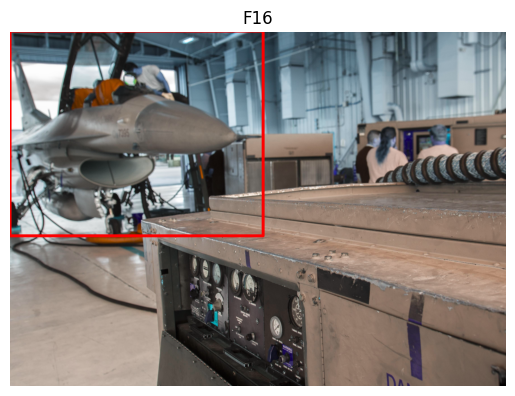

In [29]:
sample_img = "Dataset/train/images/" + sorted(os.listdir("Dataset/train/images"))[0]
sample_bbox = "Dataset/train/labels/" + sorted(os.listdir("Dataset/train/labels"))[0]
plot_bounding_boxes(sample_img, sample_bbox)

In [30]:
# verifying the class index
pd.read_csv("data/dataset/" + sorted(os.listdir("Dataset/train/labels"))[0][:-3] + "csv")

,filename,width,height,class,xmin,ymin,xmax,ymax
0,000106393cfe2343888c584e65fd2274,3520,2514,F16,0,0,1796,1451


## 4. Building the Model

### 4.1. YoloV8s

In [31]:
%%writefile Dataset/data.yaml
train: train/images
val: valid/images

nc: 60

names: ['F16', 'F18', 'F22', 'F35', 'JAS39', 'B52', 'JH7', 'KF21', 'US2', 'Be200', 'EF2000', 'C2', 'P3', 'E2', 'Su25', 'XB70', 'KC135', 'F15', 'B2', 'Tu160', 'C5', 'Mig31', 'B1', 'C130', 'A10', 'V22', 'F117', 'WZ7', 'E7', 'AG600', 'KJ600', 'RQ4', 'Tu22M', 'SR71', 'J10', 'Mirage2000', 'AV8B', 'Tu95', 'Rafale', 'A400M', 'F14', 'F4', 'YF23', 'JF17', 'Su57', 'MQ9', 'J20', 'Su34', 'H6', 'C17', 'Y20', 'Su24', 'C390', 'TB2', 'An72', 'Tornado', 'U2', 'Vulcan', 'TB001', 'B21']

Writing Dataset/data.yaml


In [32]:
import os

yaml_path = "Dataset/data.yaml"
print(os.path.exists(yaml_path))  # This should print: True

True


In [33]:
 
import yaml

# Path to the Ultralytics settings file
settings_path = '/home/jupyter/.config/Ultralytics/settings.yaml'

# Load the current settings
with open(settings_path, 'r') as file:
    settings = yaml.safe_load(file)

# Print the current settings to verify
print(settings)

if 'datasets_dir' in settings:
    settings['datasets_dir'] = '/home/jupyter/test'
else:
    settings['datasets_dir'] = '/home/jupyter/test'  # Add the key if it doesn't exist

# Print the updated settings to verify
print(settings)

# Save the updated settings back to the file
with open(settings_path, 'w') as file:
    yaml.safe_dump(settings, file)

print("Settings updated successfully.")

{'settings_version': '0.0.4', 'datasets_dir': '/home/jupyter/test/datasets', 'weights_dir': 'weights', 'runs_dir': 'runs', 'uuid': '401d35b361edfca39097700ccc92c8e0ae14bb064fd4ec2a50bf4e0659d6858d', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}
{'settings_version': '0.0.4', 'datasets_dir': '/home/jupyter/test', 'weights_dir': 'weights', 'runs_dir': 'runs', 'uuid': '401d35b361edfca39097700ccc92c8e0ae14bb064fd4ec2a50bf4e0659d6858d', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}
Settings updated successfully.


In [4]:
import torch
import os
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


# Debug CUDA environment
print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")
print(f"torch.cuda.device_count(): {torch.cuda.device_count()}")
print(f"os.environ['CUDA_VISIBLE_DEVICES']: {os.environ.get('CUDA_VISIBLE_DEVICES')}")

Using device: cuda
torch.cuda.is_available(): True
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: 1


In [ ]:
from ultralytics import YOLO
# Load the model
model_1_yolov8s = YOLO("yolov8s.pt")
# Check if CUDA is available
 
# Training
model_1_100_epochs_results = model_1_yolov8s.train(
    data='Dataset/data.yaml',
    imgsz=640,
    epochs=100,
    batch=6,
    device=device,  # Specify the device here
    workers=2,  # Number of data loading workers (threads)
    name='YOLOv8s_100e_run2',
    # resume= True, 
    project='runs/train',  # Save results to specified project 
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 112MB/s] 


Ultralytics YOLOv8.2.71 🚀 Python-3.10.14 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=Dataset/data.yaml, epochs=100, time=None, patience=100, batch=6, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=2, project=runs/train, name=YOLOv8s_100e_run2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 22.0MB/s]


Overriding model.yaml nc=80 with nc=60

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 109MB/s]


AMP: checks passed ✅


/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /home/jupyter/test/Dataset/train/labels... 10657 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10657/10657 [00:10<00:00, 1049.37it/s]


train: New cache created: /home/jupyter/test/Dataset/train/labels.cache


val: Scanning /home/jupyter/test/Dataset/valid/labels... 2691 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2691/2691 [00:02<00:00, 1027.07it/s]


val: New cache created: /home/jupyter/test/Dataset/valid/labels.cache
Plotting labels to runs/train/YOLOv8s_100e_run2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000515625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/train/YOLOv8s_100e_run2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.88G     0.9522      3.989      1.277          5        640: 100%|██████████| 1777/1777 [03:23<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:24<00:00,  9.28it/s]


                   all       2691       4042      0.267     0.0938     0.0356     0.0285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.72G     0.9358      3.164      1.226          2        640: 100%|██████████| 1777/1777 [03:18<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.45it/s]


                   all       2691       4042      0.339      0.145     0.0571     0.0452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.65G      1.055      3.141      1.297          1        640: 100%|██████████| 1777/1777 [03:17<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.46it/s]


                   all       2691       4042      0.305      0.117     0.0548       0.04

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.65G      1.141      3.181      1.342          2        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.49it/s]


                   all       2691       4042      0.265      0.156     0.0697     0.0514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.68G      1.094      3.048      1.316          6        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.49it/s]


                   all       2691       4042      0.282      0.172     0.0944     0.0696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.72G      1.053      2.937      1.294          1        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.52it/s]


                   all       2691       4042      0.298      0.212      0.119      0.094

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.74G      1.009       2.83      1.264          4        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.62it/s]


                   all       2691       4042      0.339      0.226      0.139      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.71G     0.9865      2.758      1.252          4        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.66it/s]


                   all       2691       4042      0.316      0.267       0.16      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.64G     0.9458      2.673      1.229          4        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.64it/s]


                   all       2691       4042      0.317      0.283      0.172       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.67G     0.9352      2.611      1.217          3        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.58it/s]


                   all       2691       4042      0.271      0.269      0.193      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.69G     0.9132      2.542      1.204          4        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.64it/s]


                   all       2691       4042      0.286       0.31      0.217      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.76G     0.8898       2.49      1.189          3        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.75it/s]


                   all       2691       4042       0.29      0.325      0.241      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.74G     0.8801      2.442       1.19          4        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.70it/s]


                   all       2691       4042      0.306      0.359      0.277      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.68G     0.8624      2.374      1.176          5        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.81it/s]


                   all       2691       4042      0.308      0.354        0.3      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.73G     0.8527      2.331      1.169          2        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.66it/s]


                   all       2691       4042      0.357      0.341      0.312      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.69G     0.8317      2.277       1.16          2        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.74it/s]


                   all       2691       4042      0.332       0.39      0.338      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.75G     0.8262      2.223      1.154          2        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.73it/s]


                   all       2691       4042      0.328      0.418      0.358      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.74G     0.8179      2.178      1.147          3        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:21<00:00, 10.69it/s]


                   all       2691       4042      0.366      0.418      0.376      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.69G     0.8088      2.142      1.141          2        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.80it/s]


                   all       2691       4042       0.38      0.387      0.366      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.76G     0.7956      2.087      1.135          5        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.76it/s]


                   all       2691       4042      0.442       0.42      0.409       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.72G     0.7854      2.061      1.122          8        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.83it/s]


                   all       2691       4042       0.44      0.411      0.417      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.65G     0.7785      2.021      1.122          1        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.83it/s]


                   all       2691       4042      0.482      0.443      0.449      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.72G     0.7737      1.986      1.121          3        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.87it/s]


                   all       2691       4042      0.546      0.413      0.461      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.71G     0.7665      1.944      1.115          1        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.87it/s]


                   all       2691       4042      0.545      0.436      0.476      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.66G       0.76       1.92      1.108          5        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.79it/s]


                   all       2691       4042      0.593      0.445      0.497      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.74G     0.7556      1.868      1.109          3        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.74it/s]


                   all       2691       4042      0.531      0.484      0.514       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.77G     0.7493      1.838      1.103          4        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.86it/s]


                   all       2691       4042      0.537      0.497      0.536      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.64G     0.7437      1.818        1.1          1        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.79it/s]


                   all       2691       4042      0.547      0.507      0.545      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.67G     0.7331      1.767      1.095          0        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.84it/s]


                   all       2691       4042      0.586      0.495      0.559      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.66G     0.7217      1.742      1.092          4        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.83it/s]


                   all       2691       4042      0.576      0.516      0.577      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.73G     0.7213      1.718       1.09          2        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.75it/s]


                   all       2691       4042      0.623        0.5      0.583      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.69G     0.7135      1.688      1.086          3        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.73it/s]


                   all       2691       4042      0.594       0.53      0.587      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       1.7G     0.7055      1.656      1.081          6        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.87it/s]


                   all       2691       4042      0.625      0.558      0.622      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.67G     0.7003      1.618      1.078          4        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.92it/s]


                   all       2691       4042      0.638      0.555      0.619      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.74G     0.7017      1.581      1.075          7        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.89it/s]


                   all       2691       4042      0.663      0.565       0.63      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.73G     0.6841      1.564      1.072          1        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.88it/s]


                   all       2691       4042      0.655      0.585      0.652      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       1.7G      0.683      1.536      1.069          1        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.82it/s]


                   all       2691       4042      0.661      0.582      0.651      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.71G     0.6857      1.514      1.068          3        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.95it/s]


                   all       2691       4042      0.683      0.582      0.659      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.65G     0.6804      1.493      1.068          6        640: 100%|██████████| 1777/1777 [03:16<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.94it/s]


                   all       2691       4042      0.637      0.624      0.671      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.66G     0.6721      1.465      1.064          5        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.89it/s]


                   all       2691       4042      0.713       0.59      0.681      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.72G     0.6742      1.447      1.063          9        640: 100%|██████████| 1777/1777 [03:15<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 225/225 [00:20<00:00, 10.84it/s]


                   all       2691       4042      0.743      0.581      0.685      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.69G     0.6618      1.404      1.054         28        640:  93%|█████████▎| 1656/1777 [03:03<00:14,  8.58it/s]

In [1]:
# zipping the results for downloading
!zip -r yolov8_100e_run2.zip runs/train/YOLOv8s_100e_run2

  adding: runs/train/YOLOv8s_100e_run2/ (stored 0%)
  adding: runs/train/YOLOv8s_100e_run2/.ipynb_checkpoints/ (stored 0%)
  adding: runs/train/YOLOv8s_100e_run2/.ipynb_checkpoints/results-checkpoint.csv (deflated 85%)
  adding: runs/train/YOLOv8s_100e_run2/events.out.tfevents.1722608166.instance-3.20430.0 (deflated 87%)
  adding: runs/train/YOLOv8s_100e_run2/labels.jpg (deflated 23%)
  adding: runs/train/YOLOv8s_100e_run2/confusion_matrix.png (deflated 18%)
  adding: runs/train/YOLOv8s_100e_run2/train_batch1.jpg (deflated 13%)
  adding: runs/train/YOLOv8s_100e_run2/confusion_matrix_normalized.png (deflated 18%)
  adding: runs/train/YOLOv8s_100e_run2/results.png (deflated 8%)
  adding: runs/train/YOLOv8s_100e_run2/P_curve.png (deflated 9%)
  adding: runs/train/YOLOv8s_100e_run2/val_batch1_pred.jpg (deflated 13%)
  adding: runs/train/YOLOv8s_100e_run2/train_batch159931.jpg (deflated 21%)
  adding: runs/train/YOLOv8s_100e_run2/args.yaml (deflated 52%)
  adding: runs/train/YOLOv8s_100e_ru

In [7]:
# evaluating the model
model_1_yolov8s.val()

Ultralytics YOLOv8.2.71 🚀 Python-3.10.14 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 14918MiB)
Model summary (fused): 168 layers, 11,148,804 parameters, 0 gradients, 28.6 GFLOPs


val: Scanning /home/jupyter/test/Dataset/valid/labels.cache... 2691 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2691/2691 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 449/449 [00:35<00:00, 12.73it/s]


                   all       2691       4042      0.811      0.721      0.801      0.733
                   F16        154        229      0.735      0.703      0.746      0.654
                   F18        119        200      0.783       0.57      0.713      0.634
                   F22         58         86      0.747       0.57      0.692      0.632
                   F35        128        165      0.769      0.703       0.79      0.689
                 JAS39         56         77      0.724      0.688      0.741      0.682
                   B52         78         97      0.887      0.629      0.809      0.735
                   JH7         22         27      0.774      0.635      0.779      0.737
                  KF21         19         21      0.755      0.735      0.843      0.789
                   US2         78         82      0.936      0.893      0.967      0.904
                 Be200         28         28      0.955      0.964      0.992      0.942
                EF200

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fede6cc5090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0

In [ ]:
import torch
from ultralytics import YOLO
model_1_yolov8s_100_epochs = YOLO("yolov8s.pt")
# Training
model_1_yolov8s_100_epochs_results = model_1_yolov8s_100_epochs.train(
    data='Dataset/data.yaml',
    imgsz=640,
    epochs=100,
    batch=5,
    device=0,  # Specify the device here
    workers=2,  # Number of data loading workers (threads)
    name='YOLOv8s_100e_1run', 
    resume=True,
    project='runs/train'  # Save results to specified project
)

Ultralytics YOLOv8.2.71 🚀 Python-3.10.14 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=Dataset/data.yaml, epochs=500, time=None, patience=50, batch=5, imgsz=640, save=True, save_period=-1, cache=disk, device=0, workers=8, project=YOLOv8, name=yolov8s3, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=yolov8s.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=True, dnn=False, plots=False, source=ultralytics/assets/, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /home/jupyter/test/Dataset/train/labels.cache... 10657 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10657/10657 [00:00<?, ?it/s]
train: Caching images (77.4GB Disk):  71%|███████   | 7535/10657 [00:20<00:12, 252.36it/s]  

In [21]:
model_1_yolov8s = YOLO("runs/train/YOLOv8s_100e_run2/weights/best.pt")
model_1_yolov8s.to('cuda')  # Force CPU usage
results = model_1_yolov8s.val()
results

Model summary (fused): 168 layers, 11,148,804 parameters, 0 gradients, 28.6 GFLOPs


val: Scanning /home/jupyter/test/Dataset/valid/labels.cache... 2691 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2691/2691 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:25<00:00,  6.55it/s]


                   all       2691       4042      0.818      0.718      0.801      0.733
                   F16        154        229      0.746      0.699      0.746      0.653
                   F18        119        200      0.787      0.575      0.712      0.634
                   F22         58         86      0.741       0.57      0.687      0.627
                   F35        128        165      0.782      0.703       0.79      0.689
                 JAS39         56         77      0.746      0.685      0.741      0.682
                   B52         78         97      0.894      0.608      0.809      0.738
                   JH7         22         27      0.791      0.593      0.784      0.741
                  KF21         19         21      0.717      0.714       0.84      0.787
                   US2         78         82       0.95       0.89      0.967      0.909
                 Be200         28         28      0.959      0.964      0.992      0.942
                EF200

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fede436abf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0

In [10]:
all_images = [img[:-3] + "jpg" for img in os.listdir("Dataset")]
train_val_images = os.listdir(train_images_path) 
train_val_images.extend(os.listdir(valid_images_path))
ignored_images = [i for i in all_images if i not in train_val_images]

len(ignored_images)

3

In [20]:
ignored_images

['data.yjpg', 'trjpg', 'vajpg']

In [14]:
 15933 - ( 10657 + 2691 )

2585

In [31]:
# plt.imshow(plt.imread("Dataset/" + ignored_images[0]))
# plt.axis("off");

## 5. Prediction

In [3]:
model_1_yolov8s = YOLO("D:\\Projects\\Military Aircraft Detection\\Local\\runs\\detect\\yolov8s_100_epochs\\weights\\best.pt")


image 1/1 /home/jupyter/test/Dataset/valid/images/eb2acdcdcc3c0454ca78ec6187fe82cc.jpg: 480x640 1 C2, 47.6ms
Speed: 3.1ms preprocess, 47.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict

image 1/1 /home/jupyter/test/Dataset/valid/images/d12732c5a0c6bda653fd68a0ac2b8c7c.jpg: 640x640 1 F35, 1 A10, 17.2ms
Speed: 4.3ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

image 1/1 /home/jupyter/test/Dataset/valid/images/e6fb2138faf47a8a625984c5dc8ef6d8.jpg: 448x640 1 C2, 49.7ms
Speed: 2.9ms preprocess, 49.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict

image 1/1 /home/jupyter/test/Dataset/valid/images/f4fb3b89b749b7c8cbd4c895ec310897.jpg: 448x640 1 B21, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict

image 1/1 /hom

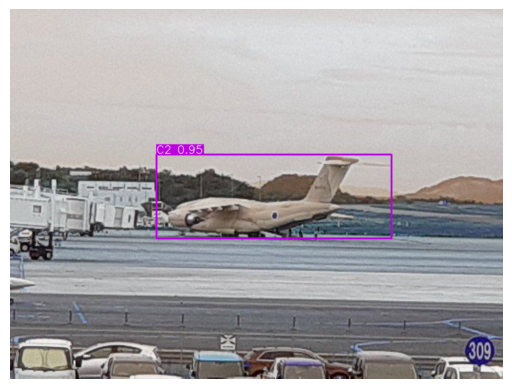

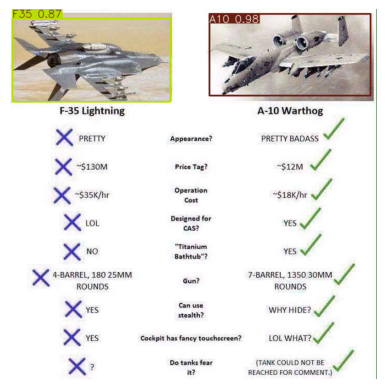

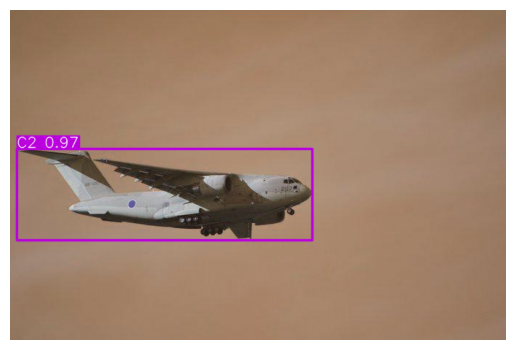

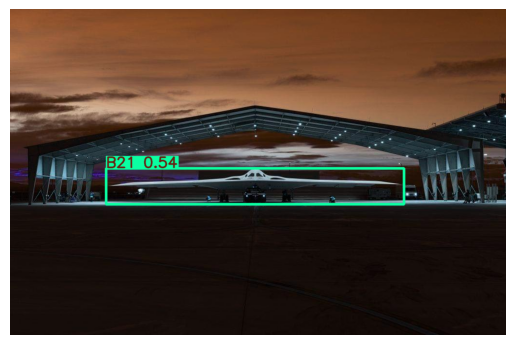

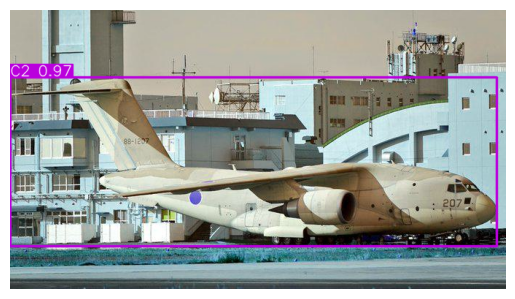

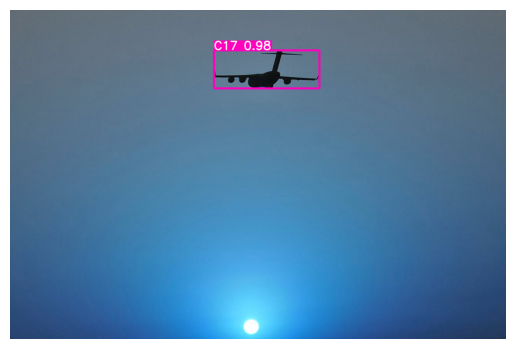

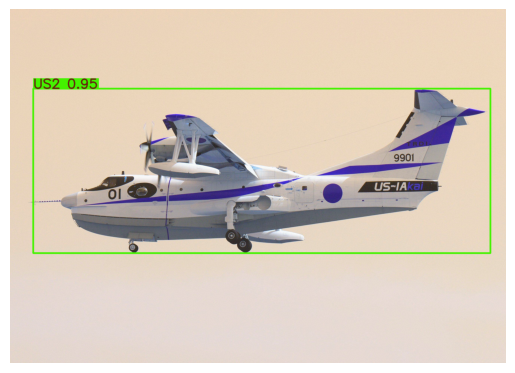

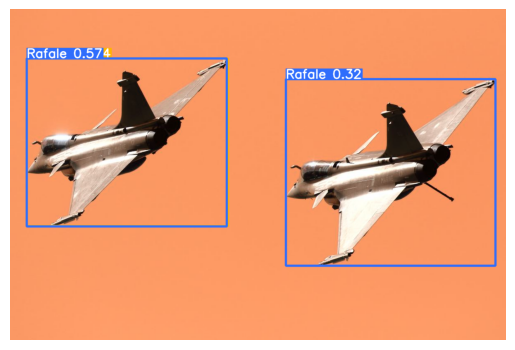

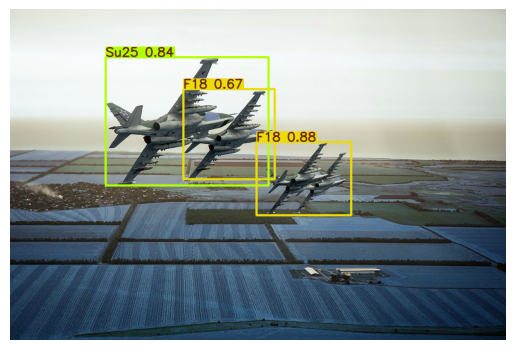

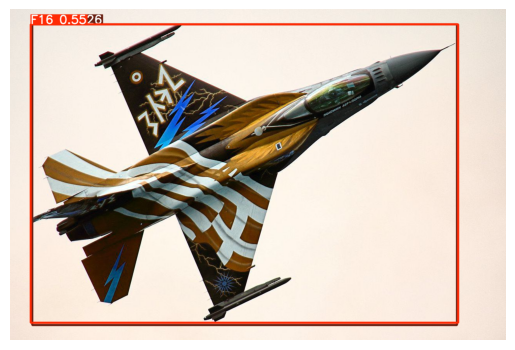

In [22]:
labels_path = []
for i in range(10):
    rand_img = random.choice(os.listdir(valid_images_path))
    img = valid_images_path + rand_img
    plt.figure()
    plt.imshow(model_1_yolov8s.predict(img, save=True)[0].plot())
    plt.axis("off")
    labels_path.append(r"dataset/" + rand_img[:-3] + "csv")

## 5. Plotting the Results

In [23]:
results_df = pd.read_csv("runs/train/YOLOv8s_100e_run2/results.csv")
results_df.head()

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,0.95220,3.9886,1.2769,0.26709,0.09383,0.03565,0.02849,0.78491,2.9436,1.1511,0.003331,0.003331,0.003331
1,2,0.93575,3.1637,1.2259,0.33911,0.14516,0.05709,0.04520,0.88209,2.9948,1.2221,0.006599,0.006599,0.006599
2,3,1.05490,3.1408,1.2971,0.30528,0.11732,0.05479,0.03995,0.98423,2.9082,1.2913,0.009800,0.009800,0.009800
3,4,1.14080,3.1807,1.3420,0.26519,0.15608,0.06972,0.05139,0.98999,2.7786,1.2969,0.009703,0.009703,0.009703
4,5,1.09390,3.0482,1.3161,0.28249,0.17167,0.09436,0.06965,0.89136,2.5972,1.2112,0.009604,0.009604,0.009604


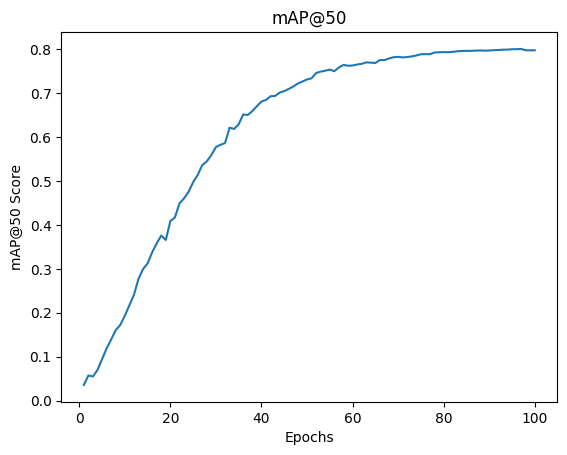

In [24]:
# plotting the MAP@50
plt.plot(range(1, 101), results_df["       metrics/mAP50(B)"])
plt.title("mAP@50")
plt.xlabel("Epochs")
plt.ylabel("mAP@50 Score");

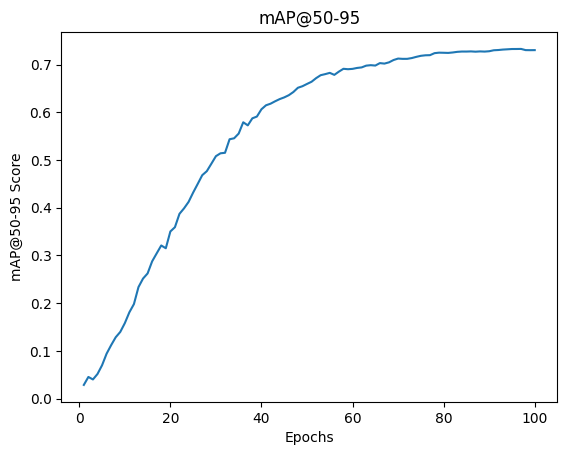

In [25]:
# plotting the MAP@50-95
plt.plot(range(1, 101), results_df["    metrics/mAP50-95(B)"])
plt.title("mAP@50-95")
plt.xlabel("Epochs")
plt.ylabel("mAP@50-95 Score");

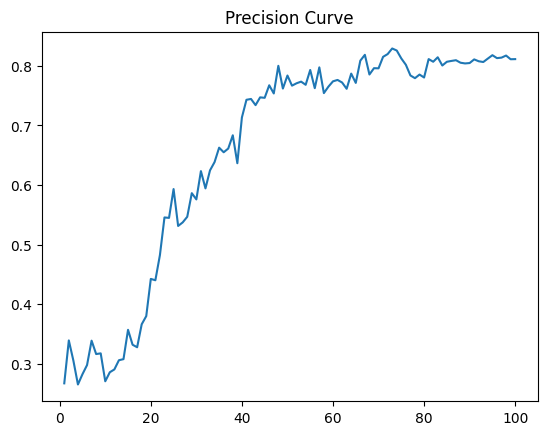

In [26]:
# plotting the Precision
plt.plot(range(1, 101), results_df["   metrics/precision(B)"])
plt.title("Precision Curve");

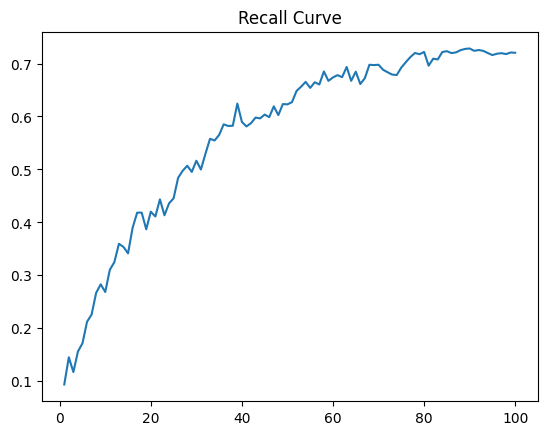

In [27]:
# plotting the Recall
plt.plot(range(1, 101), results_df["      metrics/recall(B)"])
plt.title("Recall Curve");

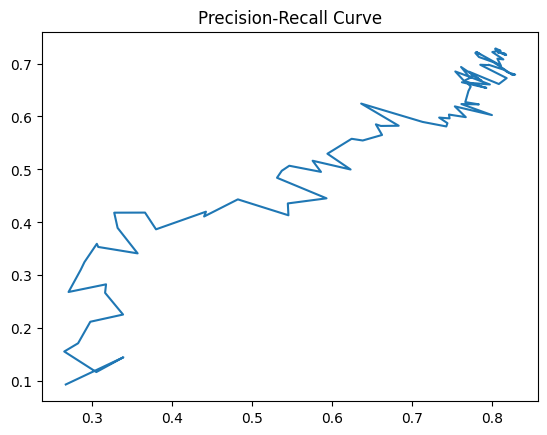

In [28]:
# plotting the Precision-Recall Curve
plt.plot(results_df["   metrics/precision(B)"], results_df["      metrics/recall(B)"])
plt.title("Precision-Recall Curve");

## 6. Building a Streamlit Web app

In [29]:
import ultralytics,torch, torchvision
torch.__version__,ultralytics.__version__, torchvision.__version__

('2.4.0+cu121', '8.2.71', '0.19.0+cu121')

In [30]:
%%writefile requirements.txt
torch==2.1.0
torchvision==0.16.0
numpy==1.24.1
ultralytics==8.0.194

Writing requirements.txt


In [32]:
# from ultralytics import YOLO
# path="runs/detect/yolov8s_100_epochs/weights/best.pt"
# model=YOLO(path)
model_1_yolov8s

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

In [35]:
%%writefile app.py
import torchvision
import ultralytics
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import streamlit as st


def predictImage(img, model):
    pred = model.predict(img)[0].plot()
    return pred

def main():
   
    with st.sidebar:
        st.title("About:")
        st.markdown(
            "- Detection of Military Aircraft using Object Detection.\n"\
            "- If you want to identify the aircrafts in an image , you can upload it here."
        )   
    st.title("Militiary Aircraft Detector")
    path="runs/train/YOLOv8s_100e_run2/weights/best.pt"
    model=YOLO(path)
    file = st.file_uploader(" Image to process:")
    button = st.button("Submit")

    if button:
        st.snow()
        if not file:
            st.error("Please upload a video or image.")

        else:
                img = plt.imread(file)
                pred = predictImage(img, model)
                st.write("Detected Image:")
                st.image(pred)
if __name__ == "__main__":
   
    main()

Overwriting app.py


In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.0.96.6:8501
  External URL: http://34.16.226.181:8501


0: 480x640 2 US2s, 45.7ms
Speed: 3.6ms preprocess, 45.7ms inference, 133.5ms postprocess per image at shape (1, 3, 480, 640)
2024-08-03 03:42:11.220 Uncaught app exception
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/streamlit/runtime/scriptrunner/exec_code.py", line 75, in exec_func_with_error_handling
    result = func()
  File "/opt/conda/lib/python3.10/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 574, in code_to_exec
    exec(code, module.__dict__)
  File "/home/jupyter/test/app.py", line 41, in <module>
    main()
  File "/home/jupyter/test/app.py", line 35, in main
    img = plt.imread(file)
  File "/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py", line 2195, in imread
    return matplotlib.image.imread(fname, format)
  File "/opt/con

In [37]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 94.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 138.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 13.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [34]:

# print(example_filenames)

NameError: name 'example_filenames' is not defined